### Sematic Segmentation

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import time
import os

In [2]:
trainPath = 'DRIVE/training/'
testPath = 'DRIVE/test/'

Text(0.5,1,'Mask')

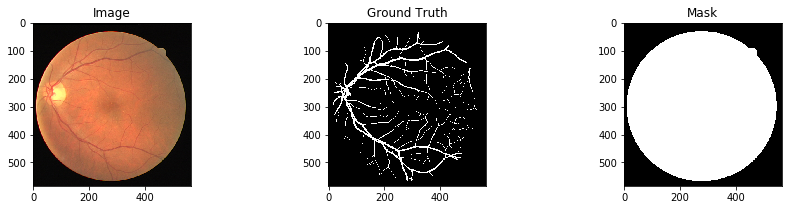

In [3]:
# Displaying sample image, groundtruth and mask from the dataset
sampleImg = np.array(Image.open(trainPath+'images/21_training.tif'))
sampleGT = np.array(Image.open(trainPath+'1st_manual/21_manual1.gif'))
sampleMask = np.array(Image.open(trainPath+'mask/21_training_mask.gif'))
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.imshow(sampleImg)
plt.title('Image')
plt.subplot(132)
plt.imshow(sampleGT,cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(sampleMask,cmap='gray')
plt.title('Mask')

In [4]:
# DRIVE dataset has 20 images for training and 20 for testing
TrainImages = torch.FloatTensor(600,3,224,224) # 20 images x 30 patches
TrainLabels = torch.FloatTensor(600,224,224)
TestImages = torch.FloatTensor(20,3,224,224)
TestLabels = torch.FloatTensor(20,224,224)

# Obtain list containing name of all files in the directoy
trainImgList = os.listdir(trainPath+'images')
testImgList = os.listdir(testPath+'images')

# Preparing train data tensors
img_no = 0
for file in trainImgList:
    imgNum = file.split('_')[0] # Image number from the filename
    im = Image.open(trainPath+'images/'+ file)
    seg = Image.open(trainPath+'1st_manual/'+str(imgNum)+'_manual1.gif')
    mask = Image.open(trainPath+'mask/'+str(imgNum)+'_training_mask.gif')
    im = np.array(im)
    seg = np.array(seg)/255
    mask = (np.array(mask)/255-seg)
    idx = np.where(mask==1)
    # Note: In the GT (seg), 0--> BG, 1--> Vessels, 2--> Tissue(mask)
    seg[idx] = 2
    
    # Augmenting training data by taking 30 patches, each of size 224x224, from the original image
    randIdx1 = np.random.randint(0,im.shape[0]-224,30) 
    randIdx2 = np.random.randint(0,im.shape[1]-224,30)
    for p in range(30):
        patch = im[randIdx1[p]:randIdx1[p]+224,randIdx2[p]:randIdx2[p]+224,:]/255
        seg_patch = seg[randIdx1[p]:randIdx1[p]+224,randIdx2[p]:randIdx2[p]+224]
        TrainImages[img_no] = torch.from_numpy(patch).transpose(0,2).unsqueeze(0)
        TrainLabels[img_no] = torch.from_numpy(seg_patch).transpose(0,1).unsqueeze(0)
        img_no += 1

# Preparing test data tensors
img_no = 0
for file in testImgList:
    imgNum = file.split('_')[0] # Image number from the filename
    im = Image.open(testPath+'images/'+ file)
    seg = Image.open(testPath+'1st_manual/'+str(imgNum)+'_manual1.gif')
    mask = Image.open(testPath+'mask/'+str(imgNum)+'_test_mask.gif')
    # Resizing the images to 224x224
    im = np.array(im.resize((224,224)))/255
    seg = np.array(seg.resize((224,224)))/255
    mask = (np.array(mask.resize((224,224)))-seg)/255
    idx = np.where(mask==1)
    # Note: In the GT (seg), 0--> BG, 1--> Vessels, 2--> Tissue(mask)
    seg[idx] = 2
    TestImages[img_no] = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
    TestLabels[img_no] = torch.from_numpy(seg).transpose(0,1).unsqueeze(0)
    img_no += 1

In [5]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([600, 3, 224, 224])
torch.Size([600, 224, 224])
torch.Size([20, 3, 224, 224])
torch.Size([20, 224, 224])


In [6]:
# Creating pytorch dataset
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 10
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=False,num_workers=4, pin_memory=True)

In [7]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


In [8]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()        
        
        # Encoder
        self.conv1c = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Decoder
        self.mup1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1d = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        
        

    def forward(self, x):
        x = self.relu1(self.conv1c(x))
        x, idx1 = self.mp1(x)    
        x = self.mup1(x, idx1)
        x = self.conv1d(x)        
        return x

In [9]:
net = SegNet()
if use_gpu:
    net = net.cuda()

In [10]:
criterion = nn.NLLLoss2d() # 2D Negative Log-Likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-3)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:198: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see http://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration: 1 /10  ;  Training Loss: 0.033149; Time consumed: 0m 6s 
At Iteration: 1 /10  ;  Testing Loss: 0.025642 ; Time consumed: 0m 6s 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration: 2 /10  ;  Training Loss: 0.032924; Time consumed: 0m 6s 
At Iteration: 2 /10  ;  Testing Loss: 0.025388 ; Time consumed: 0m 6s 
At Iteration: 3 /10  ;  Training Loss: 0.032742; Time consumed: 0m 6s 
At Iteration: 3 /10  ;  Testing Loss: 0.025069 ; Time consumed: 0m 6s 
At Iteration: 4 /10  ;  Training Loss: 0.032547; Time consumed: 0m 6s 
At Iteration: 4 /10  ;  Testing Loss: 0.024941 ; Time consumed: 0m 6s 
At Iteration: 5 /10  ;  Training Loss: 0.032432; Time consumed: 0m 6s 
At Iteration: 5 /10  ;  Testing Loss: 0.024819 ; Time consumed: 0m 6s 
At Iteration: 6 /10  ;  Training Loss: 0.032299; Time consumed: 0m 6s 
At Iteration: 6 /10  ;  Testing Loss: 0.024703 ; Time consumed: 0m 6s 
At Iteration: 7 /10  ;  Training Loss: 0.032205; Time consumed: 0m 6s 
At Iteration: 7 /10  ;  Testing Loss: 0.024619 ; Time consumed: 0m 6s 
At Iteration: 8 /10  ;  Training Loss: 0.032127; Time consumed: 0m 6s 
At Iteration: 8 /10  ;  Testing Loss: 0.024490 ; Time consumed: 0m 6s 
At Ite

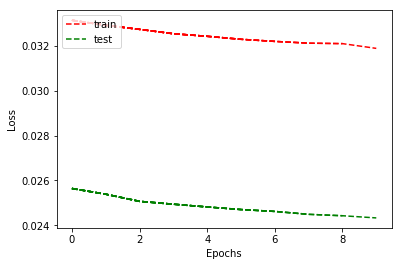

In [12]:
iterations = 10
trainLoss = []
testLoss = []
start = time.time()

for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0   
    net.train(True) # For training
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.long().cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels.long())      
 
        
        # Feed-forward input data through the network
        outputs = net(inputs)
        # Compute loss/error
        loss = criterion(F.log_softmax(outputs), labels)      
        # Initialize gradients to zero
        optimizer.zero_grad()                  
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data[0]          
    avgTrainLoss = runningLoss/600.0    
    trainLoss.append(avgTrainLoss)
  
    
    # Evaluating performance on test set for each epoch
    net.train(False) # For testing
    test_runningLoss = 0    
    for data in testLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.long().cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels.long())         
        outputs = net(inputs)       
         # Compute loss/error
        loss = criterion(F.log_softmax(outputs), labels)      
        # Accumulate loss per batch
        test_runningLoss += loss.data[0] 
        
    avgTestLoss = test_runningLoss/20.0    
    testLoss.append(avgTestLoss)
        
    # Plotting Loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r--',label='train')        
    plt.plot(range(epoch+1),testLoss,'g--',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
      
    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,epochEnd//60,epochEnd%60))
    print('At Iteration: {:.0f} /{:.0f}  ;  Testing Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTestLoss,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Text(0.5,1,'Tissue')

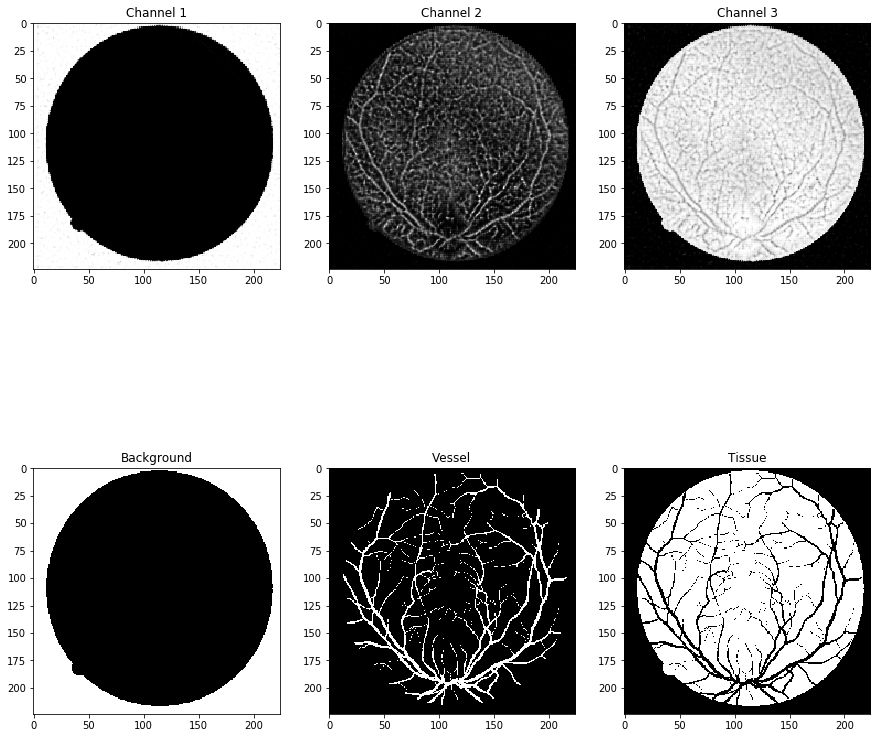

In [13]:
# Visualizing segmentation on one of the test images
randIdx = np.random.randint(20)
testImg = TestImages[randIdx]
testLab = TestLabels[randIdx].numpy()

# Feed-forward 
segImg = net(Variable(testImg).unsqueeze(0).cuda())
# Applying softmax to get class probabilities
segImg_np = F.softmax(segImg).data.cpu().squeeze(0).numpy()

# Displaying segmented output and ground truth
plt.figure(figsize=(15,15))
plt.subplot(231)
plt.imshow(segImg_np[0,:,:],cmap='gray')
plt.title('Channel 1')
plt.subplot(232)
plt.imshow(segImg_np[1,:,:],cmap='gray')
plt.title('Channel 2')
plt.subplot(233)
plt.imshow(segImg_np[2,:,:],cmap='gray')
plt.title('Channel 3')


bg = testLab==0
vessel = testLab==1
tissue = testLab==2
plt.subplot(234)
plt.imshow(bg,cmap='gray')
plt.title('Background')
plt.subplot(235)
plt.imshow(vessel,cmap='gray')
plt.title('Vessel')
plt.subplot(236)
plt.imshow(tissue,cmap='gray')
plt.title('Tissue')